## Image Classification Model Deployment
**Belajar Pengembangan Machine Learning**



**Imam Sasongko Jati**

Instalasi Package Kaggle

In [181]:
!pip install -q kaggle

Upload file API dari akun Kaggle

In [182]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sasjati","key":"0ec9651f02f7cb043c8267a98bdf8819"}'}

In [183]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


Mendownload dataset berupa kumpulan gambar binatang dari Kaggle [teks link](https://https://www.kaggle.com/madisona/translated-animals10/version/1)

In [184]:
!kaggle datasets download -d madisona/translated-animals10

 99% 578M/586M [00:05<00:00, 88.8MB/s]
100% 586M/586M [00:05<00:00, 108MB/s] 


Membuat direktori baru sebagai tempat untuk mengunzip dataset

In [185]:
!mkdir datapict
!unzip -qq translated-animals10.zip -d datapict
!ls datapict

animals10


Instalasi Package tree digunakan untuk melihat susunan direktori

In [186]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


Melihat susunan direktori baru yang telah dibuat

In [187]:
!tree -d datapict/

datapict/
└── animals10
    └── raw-img
        ├── butterfly
        ├── cat
        ├── chicken
        ├── cow
        ├── dog
        ├── elephant
        ├── horse
        ├── sheep
        ├── spider
        └── squirrel

12 directories


Menghapus beberapa direktori dari dataset yang tidak diperlukan dalam pembuatan model

In [188]:
import shutil
#hapus direktori

shutil.rmtree('datapict/animals10/raw-img/cat')
shutil.rmtree('datapict/animals10/raw-img/cow')
shutil.rmtree('datapict/animals10/raw-img/dog')
shutil.rmtree('datapict/animals10/raw-img/elephant')
shutil.rmtree('datapict/animals10/raw-img/horse')
shutil.rmtree('datapict/animals10/raw-img/sheep')
shutil.rmtree('datapict/animals10/raw-img/squirrel')

Melihat susunan direktori yang baru

In [189]:
!tree -d datapict/

datapict/
└── animals10
    └── raw-img
        ├── butterfly
        ├── chicken
        └── spider

5 directories


Instalasi Package tqdm untuk melakukan split direktori pada dataset

In [190]:
!pip install split_folders tqdm

Membagi dataset menjadi data train(80%) dan data validasi(20%)

In [191]:
import splitfolders

splitfolders.ratio('datapict/animals10/raw-img/', output='datapict/animals10/raw-img/data_model', seed=3, ratio=(.8, .2))

Copying files: 10031 files [00:01, 5133.12 files/s]


In [192]:
import os

#Direktori Utama
base_dir = 'datapict/animals10/raw-img/data_model'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
#Direktori Train
train_butterfly_dir = os.path.join(train_dir, 'butterfly')
train_chicken_dir = os.path.join(train_dir, 'chicken')
train_spider_dir = os.path.join(train_dir, 'spider')
#Direktori Validasi
validation_butterfly_dir = os.path.join(validation_dir, 'butterfly')
validation_chicken_dir = os.path.join(validation_dir, 'chicken')
validation_spider_dir = os.path.join(validation_dir, 'spider')

Mencetak 2 gambar secara acak dari masing-masing direktori train

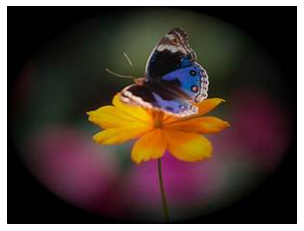

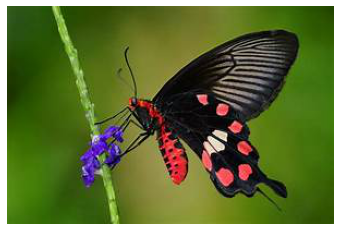

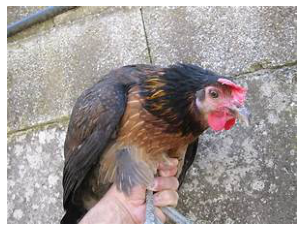

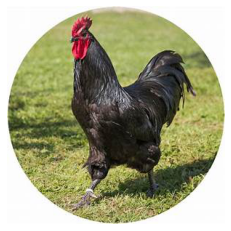

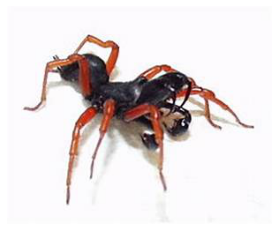

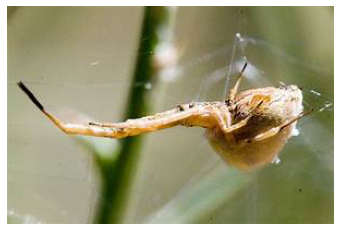

In [193]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

butterfly_files = os.listdir(train_butterfly_dir)
chicken_files = os.listdir(train_chicken_dir)
spider_files = os.listdir(train_spider_dir)

pic_index = random.randrange(0, 1000)

next_butterfly = [os.path.join(train_butterfly_dir, fname) 
                for fname in butterfly_files[pic_index-2:pic_index]]
next_chicken = [os.path.join(train_chicken_dir, fname) 
                for fname in chicken_files[pic_index-2:pic_index]]
next_spider = [os.path.join(train_spider_dir, fname) 
                for fname in spider_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_butterfly+next_chicken+next_spider):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

Instalasi Package TensorFlow

In [194]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.5.0


Membuat objek ImageDataGenerator untuk data training dan data validasi

In [195]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

Dengan objek ImageDataGenerator yang telah dibuat, dilakukan persiapan untuk data latih yang akan digunakan untuk melatih model yang dibuat.

In [196]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=20,
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=20, 
        class_mode='categorical')

Found 8023 images belonging to 3 classes.
Found 2008 images belonging to 3 classes.


Data telah siap dan dilanjutkan dengan membangun arsitektur CNN dengan model sekuensial.

In [197]:
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Memasukkan fungsi compile pada objek model dengan loss function menggunakan 'categorical_crossentropy' dan optimizer 'adam'

In [198]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

Membuat fungsi callback yang akan membuat proses training akan berhenti ketika kondisi akurasi tercapai

In [202]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80 and logs.get('val_accuracy')>0.80):
      print("\nAkurasi diatas 80%, training selesai!")
      self.model.stop_training = True

callbacks = myCallback()

In [203]:
history = model.fit(train_generator, 
                    epochs = 50, 
                    steps_per_epoch = 32,
                    validation_data = validation_generator, 
                    validation_steps = 8,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/50
32/32 [==============================] - 51s 2s/step - loss: 1.0112 - accuracy: 0.4875 - val_loss: 0.8812 - val_accuracy: 0.5375
Epoch 2/50
32/32 [==============================] - 51s 2s/step - loss: 0.9580 - accuracy: 0.5453 - val_loss: 0.9573 - val_accuracy: 0.5437
Epoch 3/50
32/32 [==============================] - 50s 2s/step - loss: 0.9441 - accuracy: 0.5219 - val_loss: 0.9337 - val_accuracy: 0.5437
Epoch 4/50
32/32 [==============================] - 49s 2s/step - loss: 0.9103 - accuracy: 0.5682 - val_loss: 0.9350 - val_accuracy: 0.5625
Epoch 5/50
32/32 [==============================] - 51s 2s/step - loss: 0.8655 - accuracy: 0.6281 - val_loss: 0.9974 - val_accuracy: 0.5750
Epoch 6/50
32/32 [==============================] - 50s 2s/step - loss: 0.8945 - accuracy: 0.5578 - val_loss: 0.9140 - val_accuracy: 0.5437
Epoch 7/50
32/32 [==============================] - 50s 2s/step - loss: 0.8994 - accuracy: 0.5797 - val_loss: 0.8406 - val_accuracy: 0.6250
Epoch 8/50
32/32 [==

Membuat plot akurasi

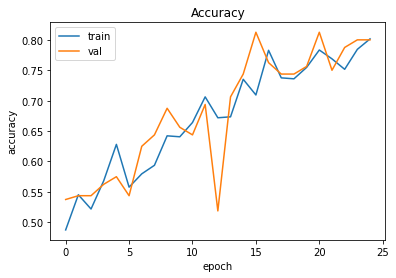

In [204]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Membuat plot loss

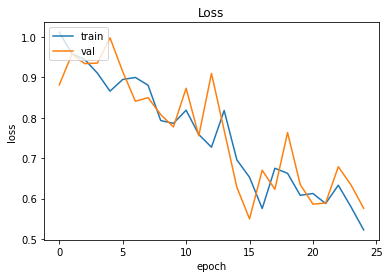

In [205]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Mencetak file .tflite

In [206]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpve5kszvv/assets


INFO:tensorflow:Assets written to: /tmp/tmpve5kszvv/assets


In [207]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13898868 Jul 14 14:32 model.tflite
